# Plot the curves for downsampled data
Both Pseudo-haploid as well as Read-Count Mode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Notebooks/Mosaic1000G_Analysis/mosaic_test/")  # Assume we are in Hapsburg Root Directory
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

from load_funcs import Summary_ROH_Calls, Summary_ROH_Calls_Error, Summary_ROH_Calls_Missing,\
                       statistics_power_df, calc_power, give_SE,\
                       false_power_statistics, return_calls_only, give_bias, false_positive_nrs
from plot_funcs import plot_power, plot_fp_distribution

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Functions for the downsampling plot

In [3]:
def load_fp_powers_error(roh, error_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(error_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(error_vec)), dtype="float") # Empty Array for Power   
    
    for i, error in enumerate(error_vec):
        print(f"Loading data for Error: {error:.4f}")
        roh.error = error
        roh.blen_cm=0  # Collect for bl 0
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers

def load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(missing_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(missing_vec)), dtype="float") # Empty Array for Power   
    
    for i, m in enumerate(missing_vec):
        print(f"Loading data for Missing: {m:.4f}")
        roh.missing = m
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "rc", output_prefix="", rd_digs=False):
    """Load False Positive Rates, as well as Power Curves for Different RC data
    base_path: The base path with which various RC 
    rc_vec: For which Readcounts to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]
    rd_digs: Whether to round the rc float to two relevants digits""" 
    fps = np.zeros(shape=(len(pw_lens), len(rc_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(rc_vec)), dtype="float") # Empty Array for Power   
    
    for i, rc in enumerate(rc_vec):
        if rd_digs:
            rc = f"{rc:.1f}"
        print(f"Loading data for mean RC: {rc} x")
        folder = base_path + rc_string + str(rc) + "/"
        roh = Summary_ROH_Calls(mosaic_folder=folder, ch=3, nr_iid = 100, blen_cm = 2, output_prefix = output_prefix, output=0)
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, power,
                         title="", savepath="", xlabel="Error Rate Target", xscale="log",
                         leg_loc="lower left", leg_loc1="upper right", ylim=[], ylim1=[],
                         height_ratios=[1,1], figsize=(6,6), fs = 14, nr_iid=100, ch_l=2.232549):
    """Plot False Positive rates as well as power against different error rates
    error_vec: Vector of Errors
    fps: List of false positive Call Numbers
    power: List of power fractions
    pw_lens: Lengths of the Power Cutoffs
    bl_lens: Lengths of Blocks simulated for power testing
    leg_loc(1): Position of the Legend (up and lower panel)
    nr_iid and ch_l: Nr individuals and length of Chromosome [M], need for FP Rate"""    
    ### Set the Colors
    cmap = cm.get_cmap("viridis_r")
    norm = plt.Normalize(1, np.max(bl_lens)) # Do the normalization
    colors = [cmap(norm(x)) for x in bl_lens]
    colors1 = [cmap(norm(x)) for x in pw_lens]

    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios)
    gs.update(hspace=0.05) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The lower subplot
    ax1 = plt.subplot(gs[1]) # The upper subplot
    
    for i in range(len(bl_lens)):
        ax.plot(error_vec, power[i,:], "o-", color = colors[i], label = f"{bl_lens[i]} cM")
    
    ax.set_ylabel("Fraction called \nwith 80% overlap", fontsize=fs)
    ax.set_xscale(xscale)
    ax.set_xticks([])
    ax.set_ylim([0,1])
    ax.legend(loc = leg_loc, title="Block Length", fontsize=fs*0.8)
    
    fps = fps / (nr_iid * ch_l) ### Normalize to Number per Morgan
    for i in range(len(pw_lens)):
        ax1.plot(error_vec, fps[i,:], "o-", color = colors1[i], label = f"> {pw_lens[i]} cM")
        #ax1.errorbar(error_vec, fps[i,:], yerr=np.sqrt(fps[i,:]))
    ax1.set_ylabel("# False Positives \nper Morgan", fontsize=fs)
    ax1.set_xscale(xscale)
    ax1.set_xlabel(xlabel, fontsize=fs)
    ax1.legend(loc = leg_loc1, title="Block Length", fontsize=fs*0.8)
    
    if len(ylim)>0:    # ylim of the upper panel 
        ax.set_ylim(ylim)
        
    if len(ylim1)>0:   # ylim of the lower panel
        ax1.set_ylim(ylim1)
        
    if len(title)>0:  # Set Title if given
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

# Various Levels of Missingness [Likely Paper]

### Pseudo-haploid

In [ ]:
%%time
### Load the Data
#missing_vec = np.linspace(0.1, 1.0, 10)
missing_vec = np.linspace(0.1, 0.5, 5)
output_prefix = "merged/" # "e01/" "diploidGT/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = n, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

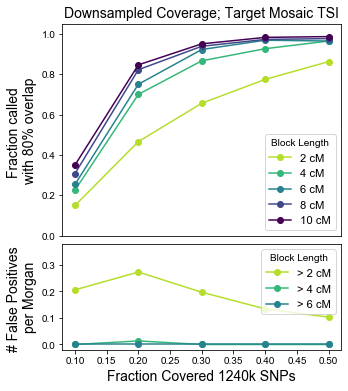

In [8]:
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, title="Downsampled Coverage; Target Mosaic TSI", 
                     savepath="",  # ./figures/manuscript/var_cov_Mosaic_TSI_PH.pdf
                     xlabel="Fraction Covered 1240k SNPs", xscale="linear",
                     leg_loc="lower right", leg_loc1="upper right", height_ratios=[2,1],
                     ylim=[0, 1.05], ylim1=[-0.02, 0.38], figsize=(5,6))   # "./figures_test/missing_01_powerfp_CHB.pdf"

## Readcount Data

In [ ]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6, 8, 10] # Can do 1,2,3 as well
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "allref/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)

In [ ]:
title = "HAPSBURG on TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     xlabel="Mean Readcount 1240k", xscale="linear", 
                     leg_loc="lower right", leg_loc1="upper right", 
                     ylim=[0, 1.05], ylim1=[-5, 142], 
                     savepath="./figures/manuscript/supplement/downsampling_mosaic/hapsburg_allref.pdf")

# Various Levels of Error

In [4]:
%%time
### Load the Data
error_vec = np.logspace(-3,-1, 8)
output_prefix = "e01/" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6]
ch=3
nr_iid=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Error(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_error(roh, error_vec, bl_lens, pw_lens)

Loading data for Error: 0.0010
Loading data for Error: 0.0019
Loading data for Error: 0.0037
Loading data for Error: 0.0072
Loading data for Error: 0.0139
Loading data for Error: 0.0268
Loading data for Error: 0.0518
Loading data for Error: 0.1000
Successfully loaded complete data!
CPU times: user 43.1 s, sys: 2.47 s, total: 45.6 s
Wall time: 3min 52s


Successfully saved to ./figures/manuscript/power_test_TSI_PH.pdf


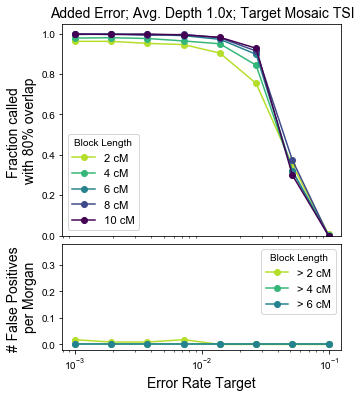

In [6]:
plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, powers, title="Added Error; Avg. Depth 1.0x; Target Mosaic TSI", 
                     savepath="./figures/manuscript/power_test_TSI_PH.pdf",  # 
                     leg_loc="lower left", leg_loc1="upper right", xlabel="Error Rate Target", xscale="log",
                     height_ratios=[2,1], ylim=[0, 1.05], ylim1=[-0.02, 0.38], figsize=(5,6))   
# "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf